In [15]:
# import sys
# !{sys.executable} -m pip install 
# import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import glacml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/data/T.csv")


#examine data columns
# dataset.head()

2.7.0


In [2]:
#drop everything but lat, long, elevation, thickness
raw_dataset = pd.read_csv("~/data/glac/T_models/T.csv")
dataset = raw_dataset.copy()
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)
dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.dropna()

#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [3]:
# sns.pairplot(train_dataset[["LON","LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [4]:
# train_dataset.describe().transpose()

In [5]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

# train_features.describe().transpose()[['mean', 'std']]

# Establish normalization layers

In [6]:
normalizer = {}
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

2022-03-15 18:51:39.922818: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-15 18:51:39.922854: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-15 18:51:39.923633: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
linear_model = {}
linear_history = {}
linear_results = {}

In [8]:
%%time
for variable_name in variable_list:

    linear_model[variable_name] = gl.build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

KeyboardInterrupt: 

In [9]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


    Variable      loss   val_loss
999     AREA  16.23797  19.210939



KeyError: 'LAT'

In [ ]:
# import glacml as gl
# gl.plot_loss(linear_history)

# Linear regression with multiple inputs

In [ ]:
linear_model = gl.build_linear_model(normalizer['ALL'])

history_full = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results["MULTI"] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

In [ ]:
df = pd.DataFrame(history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)



In [ ]:
plot_loss(history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [11]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [ ]:
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [ ]:
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name_dnn] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

In [ ]:
for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(2,2,i+1)
    plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [12]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [13]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 55.5 s, sys: 25.4 s, total: 1min 20s
Wall time: 29.4 s


In [ ]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)


In [ ]:
plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 120.0)

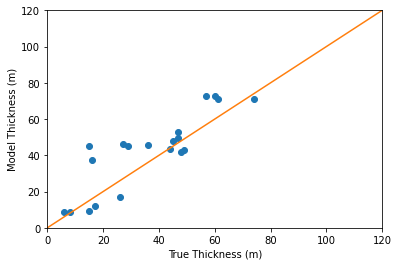

In [17]:
y = dnn_full_model.predict(test_features)
fig,ax=plt.subplots()
fig.patch.set_facecolor('w')
plt.plot(test_labels,y,"o")
plt.plot((0,120),(0,120),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,120))
plt.ylim((0,120))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

In [18]:
#split the dataset and reserve some to test what was trained.
# train_dataset = dataset.sample(frac=0.8, random_state=1)
# test_dataset = dataset.drop(train_dataset.index)


RGI = pd.read_csv("/home/sa42/data/glac/glims/glims_extra/dump2/01_rgi60_Alaska.csv")
RGI = RGI.drop("RGIId", axis=1)
RGI = RGI.drop("GLIMSId", axis=1)
RGI = RGI.drop("BgnDate", axis=1)
RGI = RGI.drop("EndDate", axis=1)
RGI = RGI.drop("O1Region", axis=1)
RGI = RGI.drop("O2Region", axis=1)
RGI = RGI.drop("Zmin", axis=1)
RGI = RGI.drop("Zmed", axis=1)
RGI = RGI.drop("Zmax", axis=1)
RGI = RGI.drop("Aspect", axis=1)
RGI = RGI.drop("Lmax", axis=1)
RGI = RGI.drop("Status", axis=1)
RGI = RGI.drop("Connect", axis=1)
RGI = RGI.drop("Form", axis=1)
RGI = RGI.drop("TermType", axis=1)
RGI = RGI.drop("Surging", axis=1)
RGI = RGI.drop("Linkages", axis=1)
RGI = RGI.drop("Name", axis=1)
RGI.rename(columns = {"CenLon":"LON",
                      "CenLat":"LAT",
                      "Area":"AREA",
                      "Slope":"MEAN_SLOPE"},
           inplace = True)
RGI

,LON,LAT,AREA,MEAN_SLOPE
0,-146.823000,63.689000,0.360,42.0
1,-146.668000,63.404000,0.558,16.0
2,-146.080000,63.376000,1.685,18.0
3,-146.120000,63.381000,3.681,19.0
4,-147.057000,63.551000,2.573,16.0
...,...,...,...,...
27103,-143.726807,60.231728,534.228,10.0
27104,-143.084000,60.532000,0.515,40.0
27105,-129.512000,54.595900,3.564,23.5
27106,-129.548000,54.620600,1.414,27.1


In [ ]:
normalizer['ALL'].adapt(np.array(RGI))
y_alaska = dnn_full_model.predict(RGI)
print(y_alaska)

In [ ]:
RGI["Prethicktion"] = y_alaska

RGI

In [ ]:
# normalizer['ALL'].adapt(np.array(RGI))
y_alaska = dnn_full_model.predict(RGI)
print(y_alaska)

In [ ]:
RGI["thickness_prethicktions"] = y_alaska
RGI.index[RGI["thickness_prethicktions"]<0]

In [ ]:
RGI["volume"] = RGI["AREA"] * (RGI["thickness_prethicktions"]/1000)
RGI["volume"].astype(float).sum()

In [ ]:
#establish normalization layers
alaska_normalizer = {}
variable_list = ("LON",
                 "LAT",
                 "AREA",
                 "MEAN_SLOPE")
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
y_alaska = dnn_full_model.predict(RGI)

print(y_alaska)

In [ ]:
# dataset_saved_for_later


# dataset_saved_for_later = dataset_saved_for_later.drop("GLACIER_ID", axis=1)
# dataset_saved_for_later = dataset_saved_for_later.drop("GlaThiDa_ID", axis=1)
# #drop the remaining null pieces from elevation
# dataset_saved_for_later = dataset_saved_for_later.dropna()
# dataset_saved_for_later.isna().sum()
dataset_saved_for_later

In [ ]:
test_features

In [ ]:
y_alaska_test = dnn_full_model.predict(RGI)

In [ ]:
plt.plot(y_alaska_test,".")
# plt.plot((0,1000),(0,1000),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((-10,3000))
plt.ylim((-200,300))

In [ ]:
print(y_alaska_test)